Calculation of theoretical distribution of distributional (intersection size) and non-distributional (Hausdorff) distances for corpora $c_i$ and $c_j$ from a KSC corpus set, assuming either semantic or non-semantic embedding.
Conduct simulations of double lottery procedure to show that the theoretical calculation corresponds to empirical simulations.

In [1]:
from scipy.stats import hypergeom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.special import comb
from collections import defaultdict


def hgprobs(sz,  n, nsame=None, nunq=True):
    #The hypergeometric distribution models drawing objects from a bin. M is the total number of objects, n is total number of Type I objects. The random variate represents the number of Type I objects in N drawn without replacement from the total population.
    #hypergeom(M, n, N)
    x = np.array(list(range(0, sz + 1))).astype(int)
    
    
    if nsame is None:
        # the other nsegments - sz are potentially the same type, want to test how many duplicates
        nsame = n - sz
    p = np.array([hypergeom.pmf(xx, n, nsame, sz) for xx in x])
    
    # number of unique items in double lottery where S1 is of size sz, or number of items in S1 that are in S2
    return n - x if nunq else x, p

# if distance is distributional and semantic
def duplicate_distance(i, j, n=10):
    i = np.clip(a=int(i), a_min=0, a_max=n)
    j = np.clip(a=int(j), a_min=0, a_max=n)

    # number of unique items in each of S^i and S^j, with respective probabilities
    nunq_j, pj = hgprobs(sz=j, n=n)
    nunq_i, pi = hgprobs(sz=i, n=n)

    # number of items in intersection, not number of unique items in the total sample
    tmp = [[hgprobs(sz=ii, nsame=jj, n=n, nunq=False) for ii in nunq_i]
           for jj in nunq_j]
    nunq_ij = [[vvv[0] for vvv in vv] for vv in tmp] #=z_ij
    p_ij = [[vvv[1] for vvv in vv] for vv in tmp]
    # now multiply conditionals to get the full unconditional probability
    for jj, ppj in enumerate(pj):
        for ii, ppi in enumerate(pi):
            p_ij[jj][ii] = p_ij[jj][ii] * ppj * ppi

    pu = defaultdict(list)
    for nn, pp in zip(nunq_ij, p_ij):
        for nnn, ppp in zip(nn, pp):
            for nnnn, pppp in zip(nnn, ppp):
                pu[nnnn].append(pppp)
    pu = {kk: sum(vv) for kk, vv in pu.items()}
    
    return (nunq_i, pi), (nunq_j, pj), pu


def double_lottery(i, n, C0, C1):
    i = np.clip(a=int(i), a_min=0, a_max=n)
    return np.append(arr=np.random.choice(a=C0, size=i, replace=False), values=np.random.choice(a=C1, size=n - i, replace=False))


def simulate_double_lottery_intersection(i, j, n, C0, C1, nsamp=1000, semantic=True):
    if semantic:
        C1 = np.abs(C1)

    Sj = np.array([double_lottery(i=j, n=n, C0=C0, C1=C1) for rr in range(nsamp)])
    Si = np.array([double_lottery(i=i, n=n, C0=C0, C1=C1) for rr in range(nsamp)])
    isec = np.array([len(np.intersect1d(ar1=aa, ar2=bb)) for aa, bb in zip(Si, Sj)])
    c = Counter(isec)
    # probabilities of various intersection sizes
    c = {kk: vv / nsamp for kk, vv in c.items()}
    c.update({kk: 0.0 for kk in range(n+1) if kk not in c})
    return c


# def euclidean(x, y, nsegments=10):
#     # x is an input point in one sample
#     # y is a sample
#     d = np.abs(x - y)
#     # maximum distance wraps
#     # d[ d == (nsegments-1)] = 0
#     return d

# def circular_euclidean(x, y, nsegments=10):
#     a = euclidean(x, y, nsegments)
#     # wrap the distance (e.g., 1 to 8 when nsegments=10, 8 can be like -1 =(8 - (10-1)), so distance =2)
#     b = euclidean(x, y - nsegments, nsegments)
#     return np.minimum(a, b)

# def hausdorff(x, y, nsegments=10, as_max=True):
#     # min--distance from each item to its closest neighbor
#     d = np.array([circular_euclidean(xx, y, nsegments).min() for xx in x])
#     return d.max() if as_max else d.mean()

# def hausdorff_metric(x, y, nsegments=10, as_max=True):
#     # make symmetric
#     d1 = hausdorff(x, y, nsegments, as_max)
#     d2 = hausdorff(y, x, nsegments, as_max)
#     return max(d1, d2)

# def hausdorff_metric(x, y, n=10, as_max=True):
#     # an item has 0 nin distance to another sample if it exists in the sample (distance 0), otherwise 1
#     # thus the hausdorff metric (the max of the minimum neighbor distances) is 0 (if all neighborhood distances are 0, hence the sets equal each other)
#     # otherwise 1 if at least one item doesn't appear
#     d1 = 1 - np.isin(x, y).astype(int)
#     d2 = 1 - np.isin(y, x).astype(int)
#     d1 = d1.max() if as_max else d1.mean()
#     d2 = d2.max() if as_max else d2.mean()
        
#     return max(d1, d2) #0 if (set(x) == set(y)) else 1

def intersection_distance(x, y):
    denom = max(len(x), len(y))
    # returns unique common items
    return 1 - len(np.intersect1d(ar1=x, ar2=y))/denom

def average_hausdorff_distance(x, y):
    # an item has 0 min distance to another sample if it exists in the sample (distance 0), otherwise 1
    # the sum of these is equal to the intersection length
    x_in_y = np.isin(x, y).mean()
    y_in_x = np.isin(y, x).mean()

    return 0.5 * ((1 - x_in_y) + (1 - y_in_x))

    
def simulate_double_lottery_hausdorff(i, j, n, C0, C1, as_max=True, nsamp=1000, semantic=True):
    # semantic will have C0=C1
    # nonsemantic will have non-overlapping C0, C1
    if semantic:
        C1 = np.abs(C1)
    
    Sj = np.array([double_lottery(i=j, n=n, C0=C0, C1=C1) for rr in range(nsamp)])
    Si = np.array([double_lottery(i=i, n=n, C0=C0, C1=C1) for rr in range(nsamp)])
    
    # multiply by n so is integer
    h = np.array([1 - average_hausdorff_distance(xx, yy) for xx, yy in zip(Si, Sj)]) * n
    h = np.round(h, 1)
    c = Counter(h)
    # probabilities of various intersection sizes
    c = {kk: vv / nsamp for kk, vv in c.items()}
    half_steps = np.round(np.linspace(start=0, stop=n, num=2*n + 1, dtype=float), 1)
    
    c.update({kk: 0.0 for kk in half_steps if kk not in c})
    return c



# def palindrome_index(nsegments):
#     nsegments = max(3, int(nsegments))
#     # i = np.clip(a=np.array(i).astype(int), a_min=0, a_max=nsegments)
#     m = int(np.floor(nsegments/2))
#     half = np.linspace(start=0, stop=m, num=m+1)
#     # event so end of half is repeated, and reverse, but drop last element
#     return np.append(half, half[-(2 if (nsegments % 2) == 0 else 1)::-1])


def E_intersection_semantic_dist(i, j, n):
    ni = n-i
    nj = n-j
    #return #nsegments - (1/nsegments) * (i*ni + j*nj - (i*j)*ni*nj/(nsegments**2) )
    return (1/n) * (n- i*ni/n) * (n - j*nj/n)

def E_intersection_nonsemantic_dist(i, j, n):
    ni = n-i
    nj = n-j
    #return #nsegments - (1/nsegments) * (i*ni + j*nj - (i*j)*ni*nj/(nsegments**2) )
    return (i*j + (n-j)*(n-i))/n

def E_intersection_nonsemantic_nondist(i, j, n):
    ni = n-i
    nj = n-j
    #return #nsegments - (1/nsegments) * (i*ni + j*nj - (i*j)*ni*nj/(nsegments**2) )
    return n - (i*j + (n-j)*(n-i))/n


def distr_of_indep_xsum(x1, x2, p1, p2, trim=False):
    # calculate probablities of sums of x1, x2 happening independently
    mx = x1.max() + x2.max()
    # consider values from 0 to mx so can just use index
    xvals = np.arange(mx + 1)
    pvals = np.zeros(mx + 1)
    for xx1, pp1 in zip(x1, p1):
        for xx2, pp2, in zip(x2, p2):
            xsum = xx1 + xx2
            # pvals[xsum] += (comb(n, i)*pp1 + comb(n, j)*pp2)
            # independent probabilities are multiplied
            pvals[xsum] += (pp1*pp2)
    if trim:
        max_nonzero = np.where(pvals > 0)[0].max()
        xvals = xvals[:(max_nonzero+1)]
        pvals = pvals[:(max_nonzero+1)]

            
    return xvals, pvals / pvals.sum()


def distr_of_indep_xsum_frac(x1, x2, p1, p2, n1, n2):
    sel1 = x1 <= n1
    sel2 = x2 <= n2
    
    x1 = x1[sel1] / n1
    p1 = p1[sel1]
    x2 = x2[sel2] / n2
    p2 = p2[sel2]
    
    if len(x1) == 0:
        pvals = dict(zip(x1, p1))
    elif len(x2) == 0:
        pvals = dict(zip(x2, p2))
    else:
        pvals = defaultdict(list)
        for xx1, pp1 in zip(x1, p1):
            for xx2, pp2, in zip(x2, p2):
                xsum = (xx1 + xx2) / 2
                pvals[xsum].append(pp1*pp2)
        pvals = {kk: sum(vv) for kk, vv in pvals.items()}
    
    return pvals

        
def probs_intersection_nonsemantic_dist(i, j, n):
    Z_1ij, p1 = hgprobs(sz=j,  n=n, nsame=i, nunq=False)
    Z_2ij, p2 = hgprobs(sz=n-j,  n=n, nsame=n-i, nunq=False)
    
    return distr_of_indep_xsum(x1=Z_1ij, x2=Z_2ij, p1=p1, p2=p2)

def probs_intersection_nonsemantic_nondist(i, j, n):
    Z_1ij, p1 = hgprobs(sz=j,  n=n, nsame=i, nunq=False)
    Z_2ij, p2 = hgprobs(sz=n-j,  n=n, nsame=n-i, nunq=False)
    
    xvals, pvals = distr_of_indep_xsum(x1=Z_1ij, x2=Z_2ij, p1=p1, p2=p2)
    # nondist is n - sum, so reverse the order of x
    return xvals[::-1], pvals

def probs_intersection_semantic_nondist(i, j, n):
    
    # number of unique items in each of S^i and S^j, with respective probabilities
    nunq_j, punq_j = hgprobs(sz=j, n=n)
    nunq_i, punq_i = hgprobs(sz=i, n=n)

    # conditional on S^j having nuj unique items, what's the probability of, out of ii or n-ii unique items, that x of the ii or n-ii are
    # in the nuj unique items
    # consider from each direction
    Z_i2j_1 = [hgprobs(sz=i, nsame=nuj, n=n, nunq=False) for nuj in nunq_j]
    #print(Z_i2j_1)
    Z_i2j_2 = [hgprobs(sz=n-i, nsame=nuj, n=n, nunq=False) for nuj in nunq_j]
    #print(Z_i2j_1)

    Z_j2i_1 = [hgprobs(sz=j, nsame=nui, n=n, nunq=False) for nui in nunq_i]
    #print(Z_j2i_1)
    Z_j2i_2 = [hgprobs(sz=n-j, nsame=nui, n=n, nunq=False) for nui in nunq_i]
    #print(Z_j2i_2)
    

    # key is number of items, value is list of probabilities of how it can happen (which are then summed)
    Z_i2j_probs = defaultdict(list)
    Z_j2i_probs = defaultdict(list)

    for pj, zi1, zi2 in zip(punq_j, Z_i2j_1, Z_i2j_2):
        # the total number of common items (including duplicates) is Z^i_1 + Z^i_2 
        Zi, pzi = distr_of_indep_xsum(x1=zi1[0], x2=zi2[0], p1=zi1[1], p2=zi2[1])
            
        for z, p in zip(Zi, pzi):
            # multiply conditional by initial probability of having that many unique values in j
            Z_i2j_probs[z].append(p * pj)
        
        # now repeat in the reverse order
    for pi, zj1, zj2 in zip(punq_i, Z_j2i_1, Z_j2i_2):
        Zj, pzj = distr_of_indep_xsum(x1=zj1[0], x2=zj2[0], p1=zj1[1], p2=zj2[1])
        
        for z, p in zip(Zj, pzj):
            # multiply conditional by initial probability of having that many unique values in i
            Z_j2i_probs[z].append(p * pi)           
        
               
    # now sum
    xvals = np.arange(n+1)
    pZi = np.array([sum(Z_i2j_probs[xx]) for xx in xvals])
    pZj = np.array([sum(Z_j2i_probs[xx]) for xx in xvals])
    
    # now get distribution of the sum, and then divide xvals by 2 to get it in the range 0--n, (then by n to get a fraction)
    Zintersection, pintersection = distr_of_indep_xsum(x1=xvals, x2=xvals, p1=pZi, p2=pZj)
    # print(pintersection.sum())
    # return distr_of_indep_xsum_frac(x1=xvals, x2=xvals, p1=pZi, p2=pZj, n1=, n2)
    return Zintersection / (n*2), pintersection / pintersection.sum()


In [2]:
# crwate corpora
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import sys  
sys.path.insert(0, '../src')
from probability_functions import *

n = 7#15
n = max(3, int(n))

# numbers i to iterate over
ivals = np.array(list(range(0, n+1))).astype(int)
# value of j
jj = 4

figsize = (10, 0.95*n)#(10,15)
nrows = int(np.ceil((n+1)/2))

# paraphrase corpora
# C0_sem = np.arange(n) #1,...,n
# C1_sem = np.arange(n) #1,...,n
# C0_nonsem = np.arange(start=n, stop=2*n) #n+1,...,2n
# C1_nonsem = np.arange(start=2*n, stop=3*n) #2n+1,...,3n

C_A = np.arange(start=1, stop=n+1) #1,...,n
C_B = -1 * C_A

embedding_types = ["semantic", "nonsemantic"]
distribution_types = ["distributional", "nondistributional"]

theor_intersection_probs = {ee: {dd: {} for dd in distribution_types} for ee in embedding_types}
theor_intersection_mu = {ee: {dd: {} for dd in distribution_types} for ee in embedding_types}
simulated_intersection_probs = {ee: {dd: {} for dd in distribution_types} for ee in embedding_types}
simulated_intersection_mu = {ee: {dd: {} for dd in distribution_types} for ee in embedding_types}

print(C_A)
print(C_B)
# example
print(double_lottery(i=5, n=n, C0=C_A, C1=C_B))

figure_template = 'figures/{}_{}_theoretical.pdf'
figure_lineplot_template = 'figures/EV_{}_lineplot.pdf'


[1 2 3 4 5 6 7]
[-1 -2 -3 -4 -5 -6 -7]
[ 3  6  7  1  5 -1 -4]


In [5]:
class KSC_probabilities:
    def est_density(x_true, p_true):
        # estimate probability of xs
        def pfunc(x_obs):
            x_in_range = np.logical_and(x_obs >= 0, x_obs <= 1)
            p_est = x_in_range.astype(int) # return 0 if out of range, 1 otherwise
            p_est[x_in_range] = np.interp(x=x_obs, xp=x_true, fp=p_true)
            return p_est
        return pfunc    
    
    def __init__(self, k=5):
        self.k = k        
        xs = np.linspace(start=0, stop=self.k, endpoint=True, num=k+1, dtype=int)
        xs_halves = np.linspace(start=0, stop=self.k, num=2*self.k + 1, endpoint=True).round(1)
        
        # xvalues to use for the probabilities
        xvals = defaultdict(list)
        xvals['distributional']['semantic'] = xvals['distributional']['nonsemantic'] = prob_vectors['nondistributional']['nonsemantic'] = (self.k - xs/self.k).tolist()
        xvals['nondistributional']['nonsemantic'] = (self.k - xs_halves/self.k).tolist()
        
        # all pair combinations of KSC corpora (value is number of items from B in each corpus)
        n_combinations = list(combinations(xs, 2))
        ells = [cc[1] - cc[0] for cc in n_combinations]
        self.unique_ells = list(range(1, self.k+1)) # 1,...,k
        prob_vectors = defaultdict(list)
        # probability of intersection equallying each of xs
        prob_vectors['distributional']['semantic'] = [duplicate_distance(cc[0], cc[1], n=self.k)[2] for cc in n_combinations]
        prob_vectors['distributional']['nonsemantic'] = [probs_intersection_nonsemantic_dist(cc[0], cc[1], n=self.k)[1] for cc in n_combinations]
        # this one includes the halves as valid values
        prob_vectors['nondistributional']['semantic'] = [probs_intersection_semantic_nondist(cc[0], cc[1], n=self.k)[1] for cc in n_combinations]
        prob_vectors['nondistributional']['nonsemantic'] = [probs_intersection_nonsemantic_nondist(cc[0], cc[1], n=self.k)[1] for cc in n_combinations]
        
        # calculate probability, at each ell, of each intersection size
        ell_locs = defautdict(list)
        for ii, ell in enumerate(self.ells):
            ell_locs[ell].append(ii)
        self.ell_probability_function = defaultdict(dict)
        for dt, vv in prob_vectors.items():
            for st, vmat in vv.items():
                avg_prob_vectors = {ell: np.mean(vv[rows,:], axis=0) for ell, rows in ell_locs.items()}
                self.ell_probability_function[st] = {ell: KSC_probabilities.est_density(x_true=xvals[dt][st], p_true=pp) for ell, pp in avg_prob_vectors.items()}
    
    def _loglike(dens_func, xvals):
        return np.log(dens_func(xvals)).sum()
    
    def log_likelihood_ratio(self, ell_vals_dict, semantic=True, explain=True):
        # ell_vals_dict consists of a dictionary where the keys are the ell separation values
        # and the values are observed distance values (between 0 and 1) for a given metric
        # likelihood in terms of 
        
        assert all([ell in self.unique_ells for ell in ell_vals_dict.keys()])
        st = 'semantic' if semantic else 'nonsemantic' # has to be specified, assumed known
        dts = ['distributional', 'nondistributional']
        llike = {dt: np.sum([self._loglike(densfunc=self.ell_probability_function[dt][st][ell], xvals=xx)
                            for ell, xx in ell_vals_dict.items()])}
        lv = llike[dts[0]] - llike[dts[1]]
        likely_type = dts[0] if lv >0 else dts[1]
        if explain:
            print('The log-likelihood in favor of being {} is {}, so the metric is most likely {}'.format(dt[0], lv, likely_type))
        
        return lv, likely_type
    
    
        
        
        

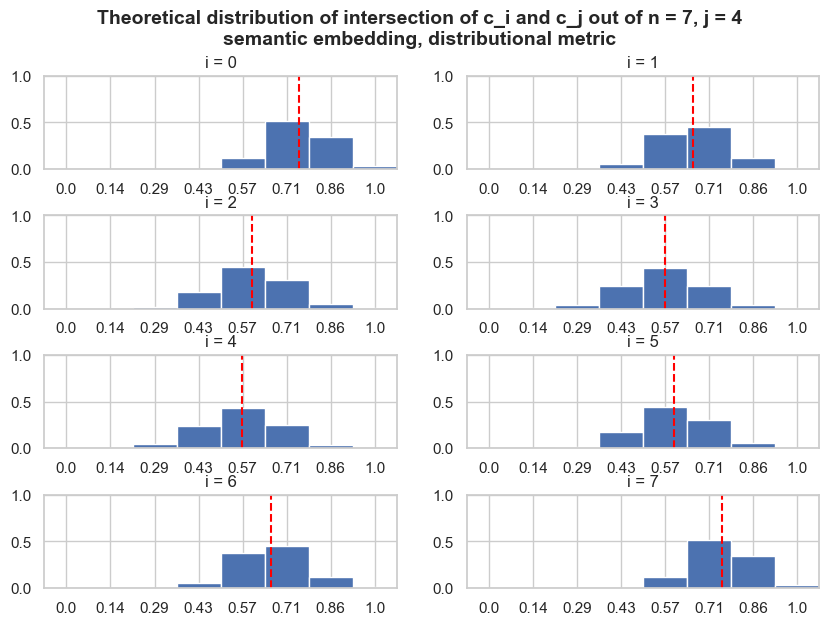

theroretical
[5.285714285714286, 4.6384839650145775, 4.206997084548105, 3.991253644314869, 3.991253644314869, 4.206997084548105, 4.6384839650145775, 5.285714285714286]
simulated
[0.7619999999999999, 0.6675714285714286, 0.5981428571428571, 0.5761428571428572, 0.5695714285714286, 0.5915714285714285, 0.6647142857142858, 0.7541428571428572]


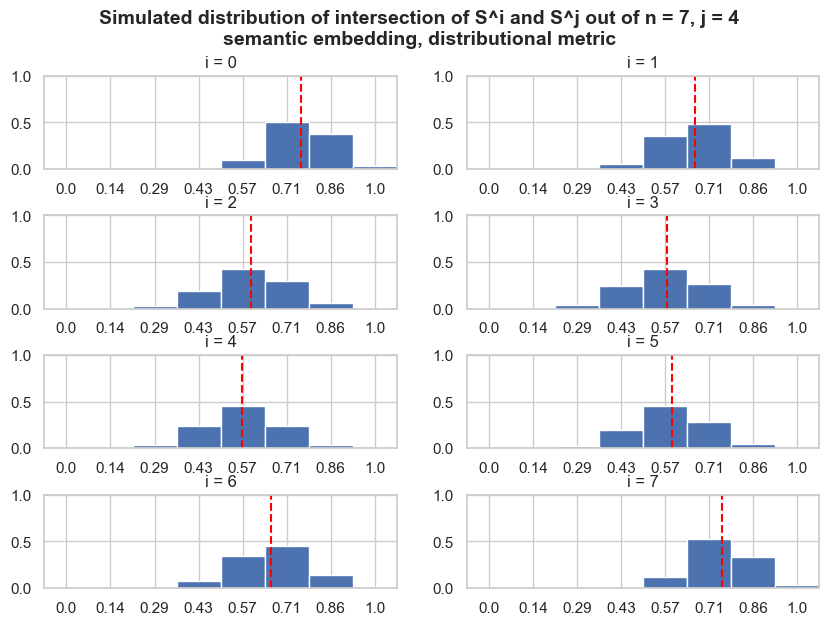

In [9]:
# distributional and semantic
dt = "distributional"
et = "semantic"

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Theoretical distribution of intersection of c_i and c_j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)

theor_intersection_probs[et][dt] = {ii: duplicate_distance(ii, jj, n)[2] for ii in ivals}
theor_intersection_probs[et][dt] = {ii: [theor_intersection_probs[et][dt][ii][iii] for iii in ivals] for ii in ivals}
theor_intersection_mu[et][dt] = {ii: np.average(a=ivals, weights=vv) for ii, vv in theor_intersection_probs[et][dt].items()}

for ii, ax in zip(ivals, fig.axes):
    ax.bar(ivals, theor_intersection_probs[et][dt][ii], width=1.0)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=ivals[0] - 0.5, right=ivals[-1] + 0.5)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    ax.axvline(x=theor_intersection_mu[et][dt][ii], color="red", linestyle="--")
    
if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False)
    
plt.savefig(figure_template.format(dt, et))
plt.show()


# now conduct simulations to see if corresponds

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Simulated distribution of intersection of S^i and S^j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)

for ii, ax in zip(ivals, fig.axes):
    # C0 and C1 are different
    hh = simulate_double_lottery_intersection(i=ii, j=jj, n=n, C0=C_A, C1=C_B, semantic=(et == "semantic"), nsamp=1000)
    simulated_intersection_probs[et][dt][ii] = [hh[iii] for iii in ivals]
    ax.bar(ivals, simulated_intersection_probs[et][dt][ii], width=1.0)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=ivals[0] - 0.5, right=ivals[-1] + 0.5)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    simulated_intersection_mu[et][dt][ii] = np.average(ivals / n, weights=simulated_intersection_probs[et][dt][ii])
    ax.axvline(x=simulated_intersection_mu[et][dt][ii] * n, color="red", linestyle="--")
    
if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False) 
# plt.show()

print("theroretical")
print([theor_intersection_mu[et][dt][ii] for ii in ivals])
print("simulated")
print([simulated_intersection_mu[et][dt][ii] for ii in ivals])

# # # palindromes
# # pal_n = palindrome_index(nsegments=nsegments)
# # pals = pal_n[ivals] + pal_n[jj]
# # avg_sim = nsegments - np.array([mu_h[ii] for ii in ivals])
# avg_sim = n - np.array([mu_formula[ii] for ii in ivals])
# prop_sim = ivals * (n - ivals) + jj * (n - jj)
# print(prop_sim)
# print(avg_sim)

# print([aa / pp for aa, pp in zip(avg_sim, prop_sim)])

# # plt.plot(pals, avg_sim, marker='o')
# # plt.xlabel('Sum of palindrome indices s_k(i) + s_k(j)')
# # plt.ylabel('N - E(intersection size)')
# # plt.title('Similarity function vs palindrome index, n={}, j={}, for varying i'.format(nsegments, jj))
# # plt.show()  

# print(np.corrcoef(prop_sim, avg_sim))
# plt.plot(prop_sim, avg_sim, marker='o')
# plt.xlabel('Theoretical proportionality')
# plt.ylabel('N - E(intersection size)')
# plt.title('Similarity function vs proportionality, n={}, j={}, for varying i'.format(n, jj))
# plt.show()  



theoretical
[3.0, 3.142857142857143, 3.2857142857142856, 3.428571428571428, 3.571428571428571, 3.7142857142857144, 3.857142857142857, 4.0]
EV
[3.         3.14285714 3.28571429 3.42857143 3.57142857 3.71428571
 3.85714286 4.        ]


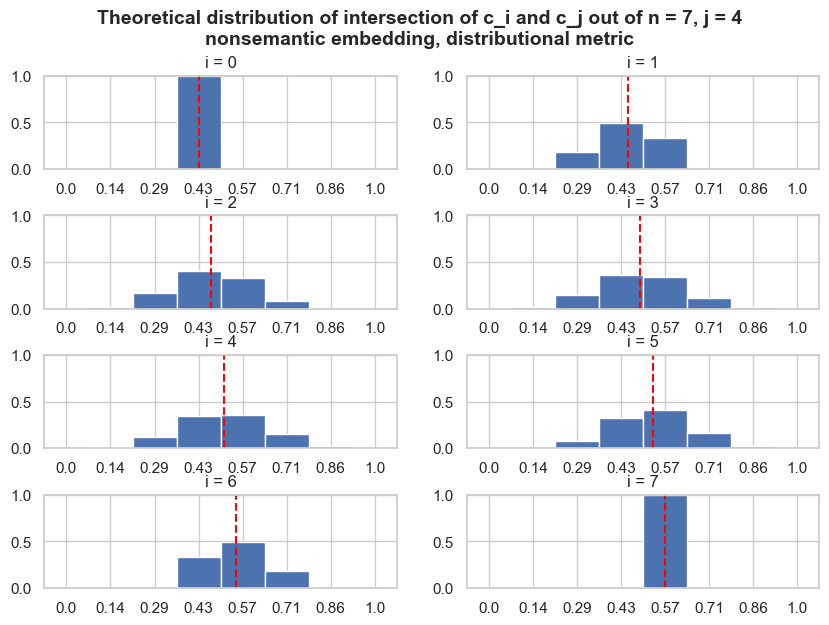

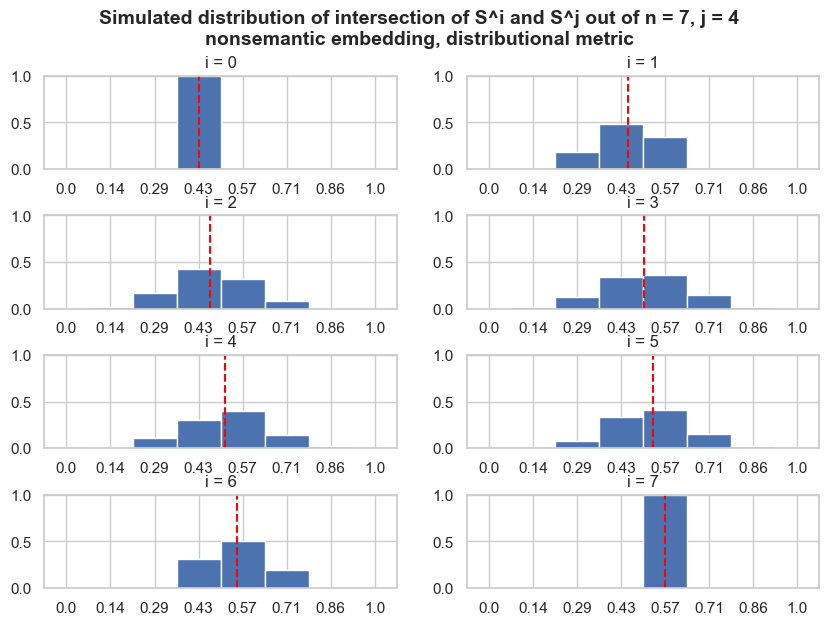

In [10]:
# distributional and non-semantic
dt = "distributional"
et = "nonsemantic"

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Theoretical distribution of intersection of c_i and c_j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)


theor_intersection_probs[et][dt] = {ii: probs_intersection_nonsemantic_dist(ii, jj, n)[1] for ii in ivals}
theor_intersection_mu[et][dt] = {ii: np.average(a=ivals, weights=vv) for ii, vv in theor_intersection_probs[et][dt].items()}

print("theoretical")
print([theor_intersection_mu[et][dt][ii] for ii in ivals])
print("EV")
print(E_intersection_nonsemantic_dist(i=ivals, j=jj, n=n))

for ii, ax in zip(ivals, fig.axes):
    ax.bar(ivals, theor_intersection_probs[et][dt][ii], width=1.0)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=ivals[0] - 0.5, right=ivals[-1] + 0.5)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    ax.axvline(x=theor_intersection_mu[et][dt][ii], color="red", linestyle="--")
    
if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False)

plt.savefig(figure_template.format(dt, et))
plt.show()

# now conduct simulations to see if corresponds

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Simulated distribution of intersection of S^i and S^j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)

for ii, ax in zip(ivals, fig.axes):
    # C0 and C1 are different
    hh = simulate_double_lottery_intersection(i=ii, j=jj, n=n, C0=C_A, C1=C_B, semantic=(et == "semantic"), nsamp=1000)
    simulated_intersection_probs[et][dt][ii] = [hh[iii] for iii in ivals]
    ax.bar(ivals, simulated_intersection_probs[et][dt][ii], width=1.0)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=ivals[0] - 0.5, right=ivals[-1] + 0.5)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    simulated_intersection_mu[et][dt][ii] = np.average(ivals / n, weights=simulated_intersection_probs[et][dt][ii])
    ax.axvline(x=simulated_intersection_mu[et][dt][ii] * n, color="red", linestyle="--")
    
if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False) 

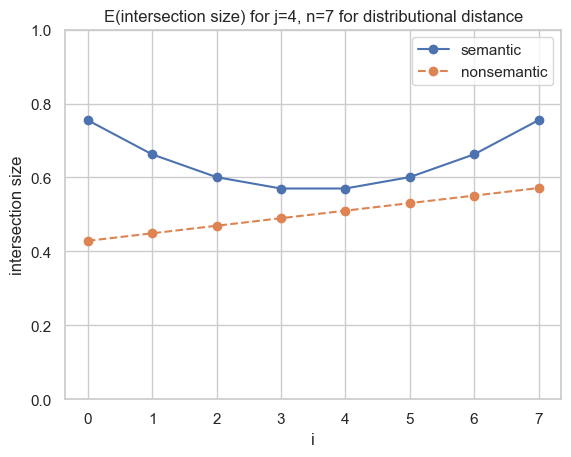

In [11]:
# compare semantic and nonsemantic
dt = "distributional"
for lab, lty in zip(["semantic", "nonsemantic"], ["solid", "dashed"]):
    plt.plot(ivals, np.array([theor_intersection_mu[lab][dt][ii] for ii in ivals]) / n, marker='o', label=lab, linestyle=lty)
plt.ylabel("intersection size")
plt.ylim(0, 1)
plt.xlabel("i")
plt.title('E(intersection size) for j={}, n={} for {} distance'.format(jj, n, dt))
plt.legend()
plt.savefig(figure_lineplot_template.format(dt))
plt.show()

theoretical
[6.142857142857143, 5.7142857142857135, 5.428571428571429, 5.285714285714286, 5.285714285714286, 5.428571428571429, 5.7142857142857135, 6.142857142857143]
EV
[3.         3.14285714 3.28571429 3.42857143 3.57142857 3.71428571
 3.85714286 4.        ]


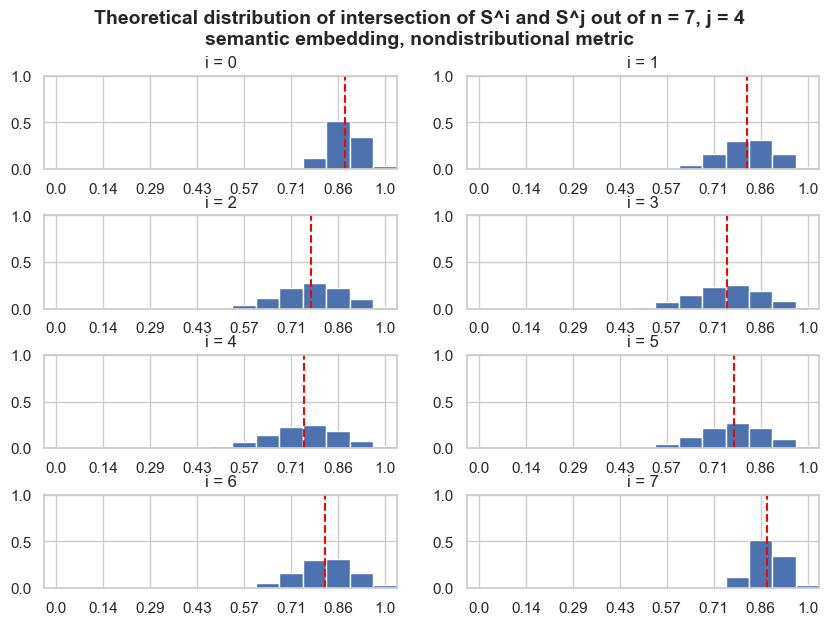

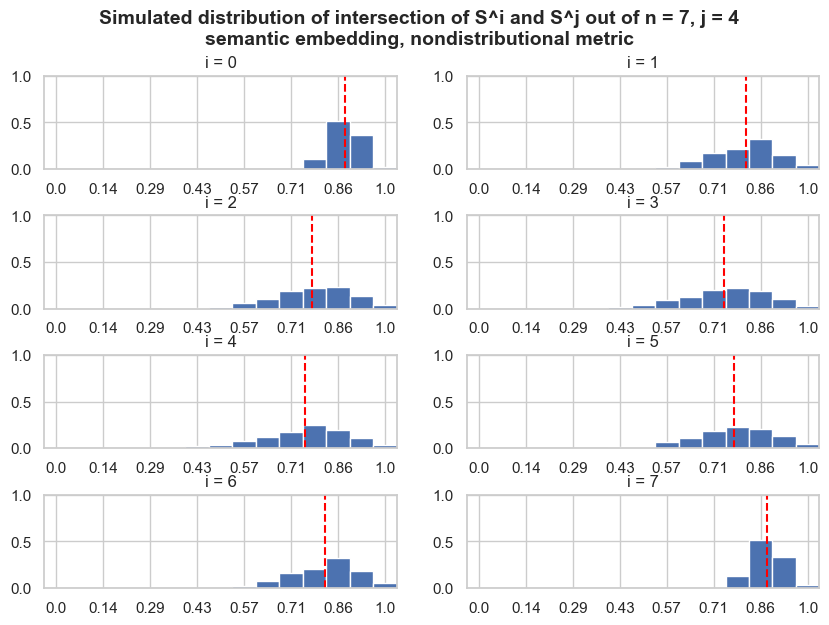

In [12]:
# non-distributional and semantic
dt = "nondistributional"
et = "semantic"

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Theoretical distribution of intersection of S^i and S^j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)

# because Hausdorff distance involves the average of two quantities that are integers, the value can ba an integer or x.5
# therefore draw bars of half widths rather than just at the integer values, before rescaling to [0,1]
half_ivals = np.linspace(start=0, stop=n, num=2*n + 1, endpoint=True)

theor_intersection_probs[et][dt] = {ii: probs_intersection_semantic_nondist(ii, jj, n)[1] for ii in ivals}
# print([vv.shape for vv in theor_intersection_probs[et][dt].values()])
theor_intersection_mu[et][dt] = {ii: np.average(a=half_ivals, weights=vv) for ii, vv in theor_intersection_probs[et][dt].items()}

print("theoretical")
print([theor_intersection_mu[et][dt][ii] for ii in ivals])
print("EV")
print(E_intersection_nonsemantic_dist(i=ivals, j=jj, n=n))


for ii, ax in zip(ivals, fig.axes):
    ax.bar(half_ivals, theor_intersection_probs[et][dt][ii], width=0.5)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=half_ivals[0] - 0.25, right=half_ivals[-1] + 0.25)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    # use ivals instead of half_ivals because 
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    ax.axvline(x=theor_intersection_mu[et][dt][ii], color="red", linestyle="--")


    
if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False)

plt.savefig(figure_template.format(dt, et))
plt.show()

# now conduct simulations to see if corresponds

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Simulated distribution of intersection of S^i and S^j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)


for ii, ax in zip(ivals, fig.axes):
    hh = simulate_double_lottery_hausdorff(i=ii, j=jj, n=n, C0=C_A, C1=C_B, semantic=(et == "semantic"), nsamp=1000)
    half_ivals = np.array(sorted(list(hh.keys())))
    half_hts = np.array([hh[vv] for vv in half_ivals])
    simulated_intersection_probs[et][dt][ii] = hh
    
    ax.bar(half_ivals, half_hts, width=0.5)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=ivals[0] - 0.25, right=ivals[-1] + 0.25)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    simulated_intersection_mu[et][dt][ii] = np.average(half_ivals / n, weights=half_hts)
    ax.axvline(x=simulated_intersection_mu[et][dt][ii] * n, color="red", linestyle="--")

if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False) 

{0: array([0., 0., 0., 1., 0., 0., 0., 0.]), 1: array([0.        , 0.        , 0.18367347, 0.48979592, 0.32653061,
       0.        , 0.        , 0.        ]), 2: array([0.        , 0.02040816, 0.16326531, 0.40816327, 0.32653061,
       0.08163265, 0.        , 0.        ]), 3: array([0.00081633, 0.01959184, 0.14693878, 0.35918367, 0.34285714,
       0.11755102, 0.01306122, 0.        ]), 4: array([0.        , 0.01306122, 0.11755102, 0.34285714, 0.35918367,
       0.14693878, 0.01959184, 0.00081633]), 5: array([0.        , 0.        , 0.08163265, 0.32653061, 0.40816327,
       0.16326531, 0.02040816, 0.        ]), 6: array([0.        , 0.        , 0.        , 0.32653061, 0.48979592,
       0.18367347, 0.        , 0.        ]), 7: array([0., 0., 0., 0., 1., 0., 0., 0.])}
theoretical
[3.0, 3.142857142857143, 3.2857142857142856, 3.428571428571428, 3.571428571428571, 3.7142857142857144, 3.857142857142857, 4.0]
EV
[3.         3.14285714 3.28571429 3.42857143 3.57142857 3.71428571
 3.85714286 

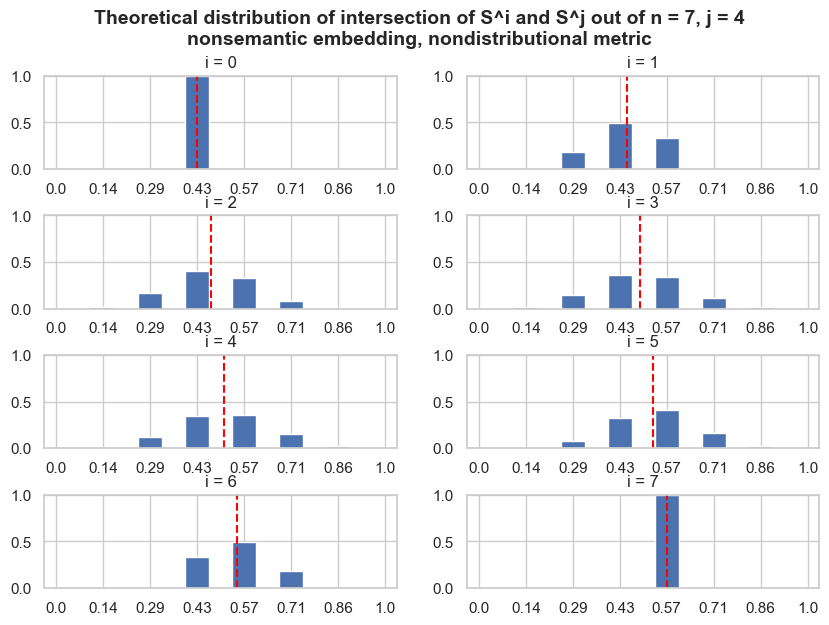

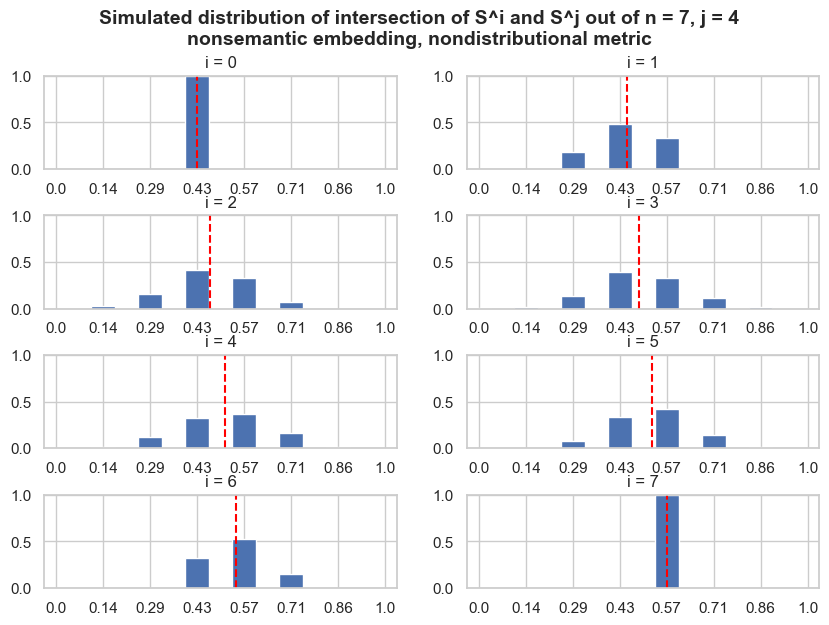

In [13]:
# non-distributional and non-semantic
dt = "nondistributional"
et = "nonsemantic"

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Theoretical distribution of intersection of S^i and S^j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)


theor_intersection_probs[et][dt] = {ii: probs_intersection_nonsemantic_nondist(ii, jj, n)[1] for ii in ivals}
theor_intersection_mu[et][dt] = {ii: np.average(a=ivals, weights=vv) for ii, vv in theor_intersection_probs[et][dt].items()}

print(theor_intersection_probs[et][dt])
print("theoretical")
print([theor_intersection_mu[et][dt][ii] for ii in ivals])
print("EV")
print(E_intersection_nonsemantic_dist(i=ivals, j=jj, n=n))


for ii, ax in zip(ivals, fig.axes):
    ax.bar(ivals, theor_intersection_probs[et][dt][ii], width=0.5)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=ivals[0] - 0.25, right=ivals[-1] + 0.25)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    ax.axvline(x=theor_intersection_mu[et][dt][ii], color="red", linestyle="--")

if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False)

plt.savefig(figure_template.format(dt, et))
plt.show()




# now conduct simulations to see if corresponds

fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
fig.suptitle("Simulated distribution of intersection of S^i and S^j out of n = {}, j = {}\n{} embedding, {} metric".format(n, jj, et, dt), fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.5)


for ii, ax in zip(ivals, fig.axes):
    hh = simulate_double_lottery_hausdorff(i=ii, j=jj, n=n, C0=C_A, C1=C_B, semantic=(et == "semantic"), nsamp=1000)
    half_ivals = np.array(sorted(list(hh.keys())))
    half_hts = np.array([hh[vv] for vv in half_ivals])
    simulated_intersection_probs[et][dt][ii] = hh
    
    ax.bar(half_ivals, half_hts, width=0.5)
    # make sure the width is exactly the length of the bars
    ax.set_xlim(left=ivals[0] - 0.25, right=ivals[-1] + 0.25)
    ax.set_ylim(top=1.0)
    # make sure xticks appear exactly at the ranges of the plotted bars, and not too frequent or not
    tick_locs = np.linspace(ivals[0], ivals[-1], min(len(ivals), 11))
    tick_labs = np.linspace(0, 1, len(tick_locs)).round(2)

    ax.set_xticks(ticks=tick_locs, labels=tick_labs)
    ax.set_title('i = {}'.format(ii))
    simulated_intersection_mu[et][dt][ii] = np.average(half_ivals / n, weights=half_hts)
    ax.axvline(x=simulated_intersection_mu[et][dt][ii] * n, color="red", linestyle="--")

    
if (n % 2) == 0:
    # get rid of last empty plot
    axs.flat[-1].set_visible(False) 

{0: 3.0, 1: 3.142857142857143, 2: 3.2857142857142856, 3: 3.428571428571428, 4: 3.571428571428571, 5: 3.7142857142857144, 6: 3.857142857142857, 7: 4.0}


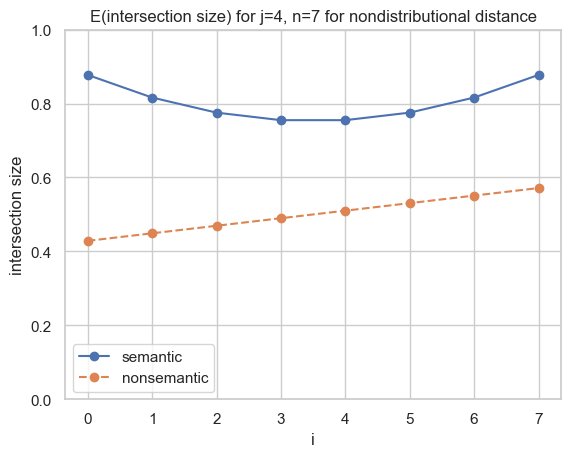

In [14]:
# compare semantic and nonsemantic
dt = "nondistributional"

print(theor_intersection_mu["nonsemantic"][dt])

for lab, lty in zip(["semantic", "nonsemantic"], ["solid", "dashed"]):
    plt.plot(ivals, np.array([theor_intersection_mu[lab][dt][ii] for ii in ivals]) / n, marker='o', label=lab, linestyle=lty)
plt.ylabel("intersection size")
plt.ylim(0, 1)
plt.xlabel("i")
plt.title('E(intersection size) for j={}, n={} for {} distance'.format(jj, n, dt))
plt.legend()
plt.savefig(figure_lineplot_template.format(dt))
plt.show()

Generating 50 KSCs with 11 elements, and n=50 sample size per corpus
[0.06324555 0.08944272 0.10198039 ... 0.10198039 0.08       0.06      ]


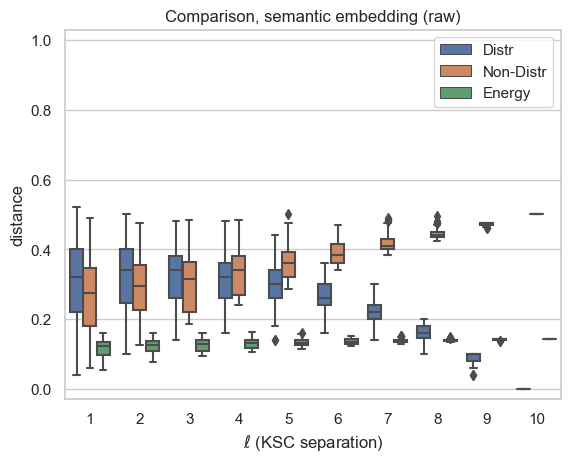

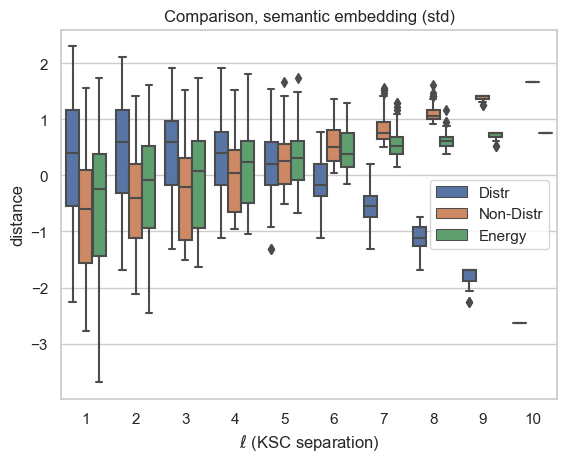

Generating 50 KSCs with 11 elements, and n=50 sample size per corpus
[0.06324555 0.08944272 0.10954451 ... 0.08485281 0.08944272 0.06324555]


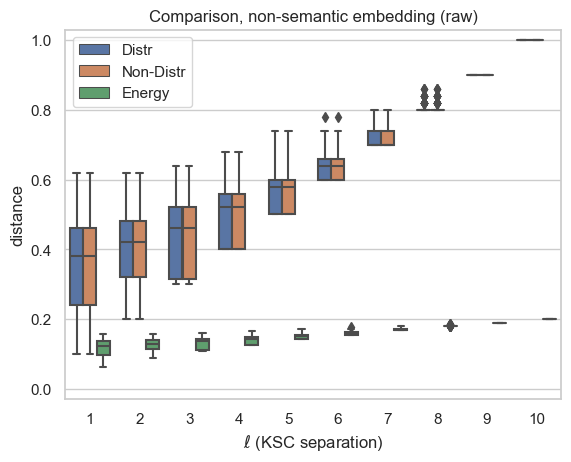

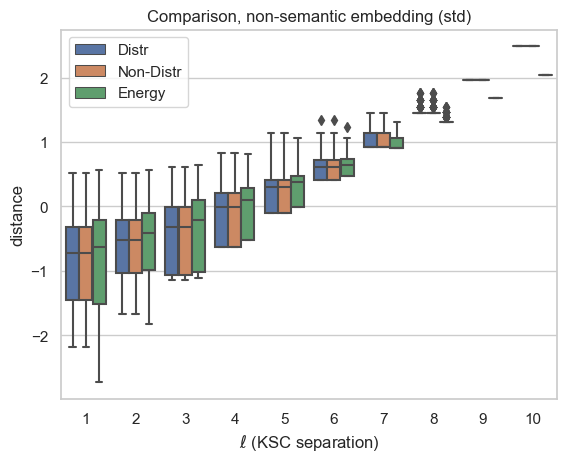

In [4]:
# KSC theoretical
from itertools import combinations
from sklearn.preprocessing import StandardScaler


def low_var_sample(wts, N, as_ctr=False):
    # ex: low_var_sample(wts=[1,4],N=2)
    # given N (sample size) and wts, a vector of numeric weights,
    # generates a set of N integer indices (valued 0...(len(wts)-1))
    # to sample from each of the groups 0...(len(wts)-1)
    # more stable than random sampling with replacement, gaurantees that resulting
    # frequencies will be at most 1 away from proportional frequencies.
    xr = np.random.uniform(low = 0, high = 1 / N, size =1)
    u = (xr + np.linspace(start=0, stop=(N - 1) / N, num=N)) * np.sum(wts)
    cs = np.cumsum(wts)
    indices = np.digitize(x=u, bins=np.array([0] + list(cs)), right=True)
    indices = indices -1
    from collections import Counter

    return Counter(indices) if as_ctr else indices


def gen_KSC_theoretical(n=30, k=10, nreps=10, semantic=True, stack=True):
    # generate distances by sampling from the theoretical distributions (not by random actual generation of KSC double lotteries)
    # here nreps is the number of times to sample from the theoretical KSC distance distribution
    # n=size of each KSC corpus
    
    n = int(max(3, n))
    k = int(min(k, n))
        
    C_A = np.arange(start=1, stop=n+1)
    C_B = C_A if semantic else -1 * C_A
        
    print('Generating {} KSCs with {} elements, and n={} sample size per corpus'.format(nreps, k+1, n))
    # number to sample from C1
    n1 = np.linspace(start=0, stop=n, endpoint=True, num=k+1, dtype=int)
    # index of n1 in KSC corpora
    nindex = list(range(len(n1)))
    
    # all pair combinations of KSC corpora (value is number of items from c1 in each corpus)
    n_combinations = list(combinations(nindex, 2))
    ells = [c[1] - c[0] for c in n_combinations]
    
    from collections import defaultdict
    ell2comb = defaultdict(list)
    for ell, c in zip(ells, n_combinations):
        ell2comb[ell].append(c)    
        
    from sklearn.preprocessing import StandardScaler
    import pandas as pd


    embed_label = 'semantic' if semantic else 'non-semantic'

    if semantic:
        distributional = {(c[0], c[1]): duplicate_distance(i=n1[c[0]], j=n1[c[1]], n=n)[2] for c in n_combinations}
        distributional = {kk: sorted([(kkk, vvv) for kkk, vvv in vv.items()], key=lambda x: x[0]) for kk, vv in distributional.items()}
        distributional = {kk: {"vals": n - np.array([vvv[0] for vvv in vv]), "probs": np.array([vvv[1] for vvv in vv])} for kk, vv in distributional.items()}
    else:
        distributional = {(c[0], c[1]): probs_intersection_nonsemantic_dist(i=n1[c[0]], j=n1[c[1]], n=n) for c in n_combinations}
        distributional = {kk: {"vals": n - vv[0], "probs": vv[1]} for kk, vv in distributional.items()}
        
    # subtract from n to make a distance
    # convert probability distribution to values by sampling
    distributional_sample = {kk: vv["vals"][low_var_sample(wts=vv["probs"], N=25)] for kk, vv in distributional.items()}
    distributional_sample_ells = {ell: np.concatenate(tuple([distributional_sample[cc] for cc in c])) for ell, c in ell2comb.items()}

    df_distributional_sample_ells =  pd.DataFrame({"l": np.concatenate(tuple([[ell]*len(vv) for ell, vv in distributional_sample_ells.items()])),
                                        "distance_raw": np.concatenate(tuple([vv for _, vv in distributional_sample_ells.items()]))})
    # divide by n to rescale
    df_distributional_sample_ells['distance_raw'] = df_distributional_sample_ells['distance_raw'] / n
    df_distributional_sample_ells['type'] = 'Distr'
    
    # standardize to z-scores
    std_distributional = StandardScaler()
    std_distributional.fit(df_distributional_sample_ells['distance_raw'].to_numpy().reshape(-1,1))
    df_distributional_sample_ells['distance_std'] = std_distributional.transform(df_distributional_sample_ells['distance_raw'].to_numpy().reshape(-1,1))
    
    # non-distributional
     
    # nondistributional
    if semantic:
        nondistr = {(c[0], c[1]): list(probs_intersection_semantic_nondist(i=n1[c[0]], j=n1[c[1]], n=n)) for c in n_combinations}
        # multiply by n so in range [0,n]
        nondistr = {kk: {"vals": vv[0]*n, "probs": vv[1]} for kk, vv in nondistr.items()}

    else:
        nondistr = {(c[0], c[1]): probs_intersection_nonsemantic_nondist(i=n1[c[0]], j=n1[c[1]], n=n) for c in n_combinations}
        nondistr = {kk: {"vals": n - vv[0], "probs": vv[1]} for kk, vv in nondistr.items()}
        
    # subtract from n to make a distance
    nondistr_sample = {kk: n - vv["vals"][low_var_sample(wts=vv["probs"], N=25)] for kk, vv in nondistr.items()}
        
    nondistr_sample_ells = {ell: np.concatenate(tuple([nondistr_sample[cc] for cc in c])) for ell, c in ell2comb.items()}
    
    df_nondistr_sample_ells =  pd.DataFrame({"l": np.concatenate(tuple([[ell]*len(vv) for ell, vv in nondistr_sample_ells.items()])),
                                        "distance_raw": np.concatenate(tuple([vv for _, vv in nondistr_sample_ells.items()]))})
    # divide by n to rescale
    df_nondistr_sample_ells['distance_raw'] = df_nondistr_sample_ells['distance_raw'] / n
    df_nondistr_sample_ells['type'] = 'Non-Distr'
    
    std_nondistr = StandardScaler()
    std_nondistr.fit(df_nondistr_sample_ells['distance_raw'].to_numpy().reshape(-1,1))
    df_nondistr_sample_ells['distance_std'] = std_nondistr.transform(df_nondistr_sample_ells['distance_raw'].to_numpy().reshape(-1,1))
 
    # convert numeric "ell" to string for boxplot
    df_combined = pd.concat([df_nondistr_sample_ells, df_distributional_sample_ells])
    df_combined['l'] = df_combined['l'].astype(str)
    
    # plot
    import seaborn as sns

    sns.set_theme(style="whitegrid")
#     # sns.set(font_scale=3)
#     if stack:
#         fig, axs = plt.subplots(2, 1, figsize=(35, 35))
    
    for tp in ['raw', 'std']:                                                                                         
                                                                                             
#         fig, axlist = plt.subplots(3, 2, figsize=(35, 35), sharey=True)
#         fig.tight_layout()
        dfeat_name = 'distance_{}'.format(tp)

#         sns.scatterplot(x='l', y=dfeat_name, data=df_distributional_sample_ells, ax=axlist[0,0], color='orange', s=300)
#         sns.regplot(x='l', y=dfeat_name, data=df_distributional_sample_ells, ax=axlist[0,0], scatter=False, truncate=False)
#         axlist[0,0].set_title('Distributional, {} embedding ({})'.format(embed_label, tp))
    
#         # now do boxplot
#         sns.boxplot(x='l', y=dfeat_name, data=df_combined.loc[df_combined['type'] == 'Distr'], ax=axlist[0,1], color='orange')
#         axlist[0,1].set_title('Distributional, {} embedding ({})'.format(embed_label, tp))
                                                                                             
#         sns.scatterplot(x='l', y=dfeat_name, data=df_nondistr_sample_ells, ax=axlist[1,0], color='orange', s=300)
#         sns.regplot(x='l', y=dfeat_name, data=df_nondistr_sample_ells, ax=axlist[1,0], scatter=False, truncate=False)
#         axlist[1,0].set_title('Non-Distributional, {} embedding ({})'.format(embed_label, tp))
    
#         # now do boxplot
#         sns.boxplot(x='l', y=dfeat_name, data=df_combined.loc[df_combined['type'] == 'Non-Distr'], ax=axlist[1,1], color='orange')
#         axlist[1,1].set_title('Non-Distributional, {} embedding ({})'.format(embed_label, tp))

#         # combine the two for comparison
#         sns.boxplot(x='l', y=dfeat_name, data=df_combined, ax=axlist[2,0], hue='type')
#         axlist[2,0].set_title('Comparison, {} embedding ({})'.format(embed_label, tp))    
#         axlist[2,1].axis('off')
    
        sns.boxplot(x='l', y=dfeat_name, data=df_combined, hue='type')
        plt.title('Comparison, {} embedding ({})'.format(embed_label, tp))
        plt.xlabel(r'$\ell$ (KSC separation)')
        plt.legend()
        if tp == 'raw':
            plt.ylim(-0.03,1.03)
        plt.savefig('figures/KSC_sim_distr_{}_{}.pdf'.format('semantic' if semantic else 'nonsemantic', tp))
    
        plt.show()


def gen_KSC_sampled(n=30, k=10, nreps=20, semantic=True, stack=True):
    # generate distances by sampling KSCs
     
    # n=size of each KSC corpus
    n = int(max(3, n))
    k = int(min(k, n))
    
    C_A = np.arange(start=1, stop=n+1)
    C_B = -1 * C_A
        
    print('Generating {} KSCs with {} elements, and n={} sample size per corpus'.format(nreps, k+1, n))
    # number to sample from C1
    n1 = np.linspace(start=0, stop=n, endpoint=True, num=k+1, dtype=int)
    # index of n1 in KSC corpora
    nindex = list(range(len(n1)))
    
    # all pair combinations of KSC corpora (value is number of items from c1 in each corpus)
    n_combinations = list(combinations(nindex, 2))
    # ells is the ksc index separation, not the gap between the actual ns
    ells = [c[1] - c[0] for c in n_combinations]
    
    # form nreps draws of a KSC corpus, drawing ns from C0 and n-ns from C1 in each corpus
    kscs = [{ii: double_lottery(i=ns, n=n, C0=C_A, C1=C_B) for ii, ns in enumerate(n1)} for rr in range(nreps)]
    # do each combination of comparison in the KSC
    distr_dist = np.concatenate([[intersection_distance(x=ksc[cc[0]], y=ksc[cc[1]], as_distance=True, semantic=semantic) for cc in n_combinations] for ksc in kscs])
    nondistr_dist = np.concatenate([[average_hausdorff_distance(x=ksc[cc[0]], y=ksc[cc[1]], semantic=semantic) for cc in n_combinations] for ksc in kscs])
    energy_dist = np.concatenate([[energy_distance(x=ksc[cc[0]], y=ksc[cc[1]], semantic=semantic, normalize=False) for cc in n_combinations] for ksc in kscs])
    print(energy_dist)
    df = pd.DataFrame({"raw": np.concatenate([distr_dist, nondistr_dist, energy_dist]),
                       "type": np.repeat(["Distr", "Non-Distr", "Energy"], nreps * len(n_combinations)),
                       "ell": ells * (nreps * 3)})
        
    # standardize to z-scores
    def standardize_vector(x):
        std_distributional = StandardScaler()
        # reshape so not flat
        xx = x.reshape(-1,1)
        std_distributional.fit(xx)
        return std_distributional.transform(xx)
    
    # standardize each type separately
    df["std"] = np.concatenate([standardize_vector(distr_dist), 
                                standardize_vector(nondistr_dist),
                                standardize_vector(energy_dist)])
    embed_label = 'semantic' if semantic else 'non-semantic'

    # plot
    import seaborn as sns

    sns.set_theme(style="whitegrid")
    # sns.set(font_scale=3)
    
    for tp in ['raw', 'std']:                                                                                         
                                                                                                 
        sns.boxplot(x='ell', y=tp, data=df, hue='type')
        plt.title('Comparison, {} embedding ({})'.format(embed_label, tp))
        plt.ylabel('distance')
        plt.xlabel(r'$\ell$ (KSC separation)')
        plt.legend()
        if tp == 'raw':
            plt.ylim(-0.03,1.03)
        plt.savefig('figures/KSC_sim_distr_{}_{}.pdf'.format('semantic' if semantic else 'nonsemantic', tp))
        plt.show()
    
# show the plot
np.random.seed(42)

gen_KSC_sampled(n=50, k=10, semantic=True, nreps=50)
gen_KSC_sampled(n=50, k=10, semantic=False, nreps=50)


# z = gen_KSC_theoretical(n=50, k=10, semantic=True, nreps=50)
# gen_KSC_theoretical(n=50, k=10, semantic=False, nreps=50)

In [20]:
x = double_lottery(i=0, n=n, C0=C_A, C1=C_B)
y = double_lottery(i=n, n=n, C0=C_A, C1=C_B)
semantic = False #True
if semantic:
    x = np.abs(x)
    y = np.abs(y)

def internal_binary(a, b):
    d = np.subtract.outer(a, b) # pairwise differences
    d[ d != 0 ] = 1.0 # convert 0s to 0 and others to 1
    return d

between = internal_binary(x, y)
within1 = internal_binary(x, x)
within2 = internal_binary(y, y)
A2 = 2 * between.mean()
B = within1.mean()
C = within2.mean()

In [21]:
print(between.mean())
print(within1.mean())
print(within2.mean())

1.0
0.8571428571428571
0.8571428571428571


In [22]:
print(x)
print(y)
print(between)
print(within1)
print(within2)

[-3 -7 -4 -5 -2 -6 -1]
[6 4 3 7 2 5 1]
[[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]
[[0 1 1 1 1 1 1]
 [1 0 1 1 1 1 1]
 [1 1 0 1 1 1 1]
 [1 1 1 0 1 1 1]
 [1 1 1 1 0 1 1]
 [1 1 1 1 1 0 1]
 [1 1 1 1 1 1 0]]
[[0 1 1 1 1 1 1]
 [1 0 1 1 1 1 1]
 [1 1 0 1 1 1 1]
 [1 1 1 0 1 1 1]
 [1 1 1 1 0 1 1]
 [1 1 1 1 1 0 1]
 [1 1 1 1 1 1 0]]


In [15]:
edist = A2 - B - C
print(A2)
print(edist)
print(edist/A2)


2.0
0.3999999999999999
0.19999999999999996


In [16]:
edist

0.3999999999999999